In [1]:
from os import walk,path,mkdir
from pandas import read_csv, DataFrame
from numpy import array, arange, log,meshgrid
from scipy import interpolate,integrate
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

In [2]:
# function that transform file in to list. input name: path and the name of the file.
def open_file(name):
    file = open(name, 'r', encoding='utf-8',
                errors='ignore')  # open the file.
    # creat a list that will be full filed with the file with a line as a list element.
    file_list = []
    for line in file:  # open a loop that cover the file.
        line = line.strip('\n')  # drop out all '\n' contained in every line.
        # change the spaces for a element of a list, ex: 'the energy is' --> ['the','energy','is'].
        line = line.split()
        file_list.append(line)  # add the line in the list file_list.
    file.close()  # close de file.
    return file_list


def head_remove(file):
    new_file = []
    i =0
    for line in file:
        if len(line)>0:
            if line[0] != '#':
                ct = i
                break
        i+=1
    return file[ct:]

def get_number(name):
    for i in range(len(name)):
        if name[len(name)-1-i] == '/':
            ct = len(name)-1-i
            break
    number = ''
    for i in range(ct,len(name)):
        try:
            float(name[i])
            number+=name[i]
        except ValueError:
            pass
    return int(number)

In [4]:
class File:
    def __init__(self):
        self.path = './'
        
    
    def files_sts(self):
        sub_dir = []
        for diretorio, subpastas, arquivos in walk(self.path ):
            for dir in subpastas:
                sub_dir.append(path.join(self.path,dir))
        line = []
        X = []; Y = []
        for i in range(len(sub_dir)):
            col = [];colx = [];coly = []
            for item in sub_dir:
                if i ==  get_number(item):
                    for diretorio, subpastas, arquivos in walk(item):
                        j = 0
                        for arq in arquivos:
                            if ('Spectroscopy' in arq) == True:
                                file = open_file(path.join(item,arq))
                                new_file = head_remove(file)
                                df = DataFrame(new_file,columns=['V','I'], dtype= float)
                                col.append(df)
                                coly.append(j)
                                colx.append(i)
                                j+=1
                            else:
                                df = read_csv(path.join(item,arq),dtype= float)
                                df = df.drop(df.columns[0],axis = 1)
                                col.append(df)
                                coly.append(j)
                                colx.append(i)
                                j+=1
            X.append(colx)
            Y.append(coly)
            line.append(col)
        return [X,Y,line]        


In [5]:
file = File()
file.path = 'heatsmaps/bulk/'
x,y,z = file.files_sts()

In [39]:
def didv(df, p):
    col = df.columns
    x = df[col[0]]; y_old = df[col[1]]*pow(10,9)
    n = int(p[0]*len(y_old)/100)
    if n%2 == 0:
        n+=1
    y = savgol_filter(y_old,n,p[1])

    h = (x[len(x)-1] - x[0])/len(x)
    deri_y = []; deri_x =[]
    for i in range(1,len(x)-1):
        d = (y[i+1]-y[i-1])/(2*h)
        deri_x.append(x[i])
        deri_y.append(d)
    return [array(deri_x),array(deri_y)]

def dos_v(df,V):
    x = df[0]; y = df[1]
    f = interpolate.interp1d(x, y)
    return f(V)

def integral(df,a,b):
    x = [];y= []
    for i in range(len(df[0])):
        if df[0][i]>=a and df[0][i]<=b:
            x.append(df[0][i])
            y.append(df[1][i])

    h = (x[len(x)-1] - x[0])/len(x)
    I = h/2*(y[0]+y[len(y)-1])
    for i in range(1,len(y)-1):
        I+=h*y[i]
    return I

def type_dop(df,p):
    col = df.columns
    x = df[col[0]]; y_old = df[col[1]]*pow(10,9)
    n = int(p[0]*len(y_old)/100)
    if n%2 == 0:
        n+=1
    y = savgol_filter(y_old,n,p[1])

    for i in range(len(x)-1):
        if y[i] == 0:
            x_point = x[i]
            break
        elif y[i]<0 and y[i+1]>0:
            x_point = x[i]
            break
        elif y[i]>0 and y[i+1]<0:
            x_point = x[i]
            break
    return x_point
def menor_valor_ln(df,p):
    col = df.columns
    x = df[col[0]]; y_old = df[col[1]]*pow(10,9)
    n = int(p[0]*len(y_old)/100)
    if n%2 == 0:
        n+=1
    y = savgol_filter(y_old,n,p[1])

    ly = log(abs(y))
    for i in range(len(ly)):
        if ly[i] == min(ly):
            return x[i]

p = (10,1)
dos =  didv(z[0][0], p)
integral(dos,-1.5,1.5)
type_dop(z[0][0],p )
menor_valor_ln(z[0][0],p)
dos_v(dos,-1)

array(14.53400139)

In [40]:
z_integral = []
z_type = []
z_log = []
z_dos_v = []
p = (10,1)
a = -1;b = 1
V = 0
for i in range(len(x)):
    col_inte = []; col_type = []; col_log = []; col_dos_v = []
    for j in range(len(y[i])):
        dos = didv(z[i][j], p)
        col_inte.append(integral(dos,a,b) )
        col_type.append( type_dop(z[i][j],p ))
        col_log.append(menor_valor_ln(z[i][j],p) )
        col_dos_v.append(dos_v(dos,V))
    z_integral.append(col_inte)
    z_type.append(col_type)
    z_log.append(col_log)
    z_dos_v.append(col_dos_v)

In [41]:
x_interp = arange(18)
y_interp = arange(40)
f = interpolate.interp2d(y_interp,x_interp,z_dos_v)
xnew = arange(0, 18, 0.01)
ynew = arange(0,40, 0.01)
xx, yy = meshgrid(ynew, xnew)
znew = f(ynew, xnew)

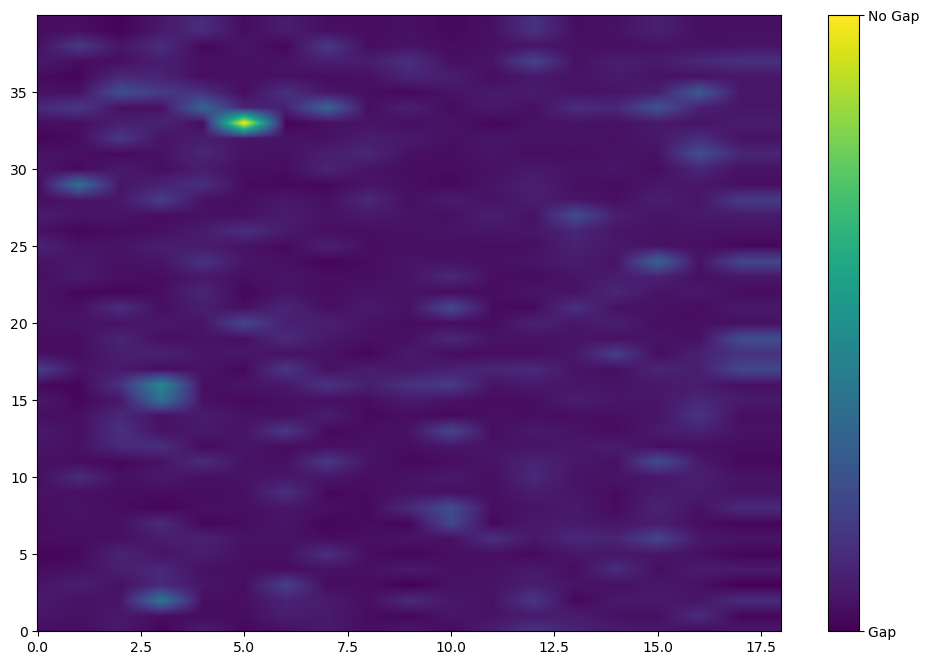

In [42]:
fig, axs = plt.subplots(figsize = (12,8))
im = axs.pcolormesh(yy,xx,znew)
#im = axs.pcolormesh(x,y,z_integral)
#axs.set_xticks(, )
cbar = fig.colorbar(im)
cbar.set_ticks([znew.min(),znew.max()],labels= ['Gap ','No Gap'])
#cbar.ax.set_yticklabels(['Gap','No Gap'])

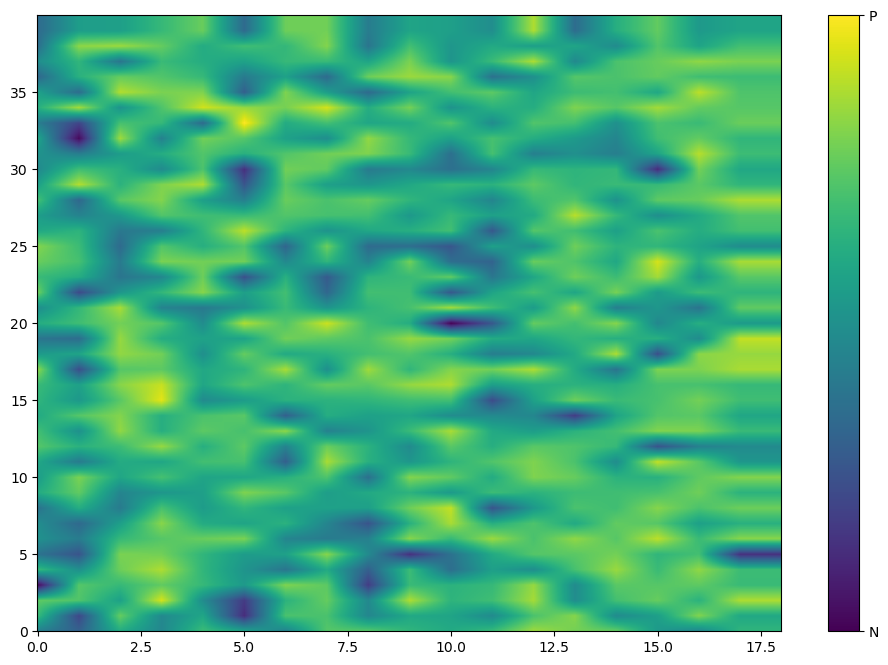

In [150]:
x_interp = arange(18)
y_interp = arange(40)
f = interpolate.interp2d(y_interp,x_interp,z_type)
xnew = arange(0, 18, 0.01)
ynew = arange(0,40, 0.01)
xx, yy = meshgrid(ynew, xnew)
znew = f(ynew, xnew)

fig, axs = plt.subplots(figsize = (12,8))
im = axs.pcolormesh(yy,xx,znew)
#im = axs.pcolormesh(x,y,z_integral)
#axs.set_xticks(, )
cbar = fig.colorbar(im)
cbar.set_ticks([znew.min(),znew.max()],labels= ['N', 'P'])
#cbar.ax.set_yticklabels(['Gap','No Gap'])

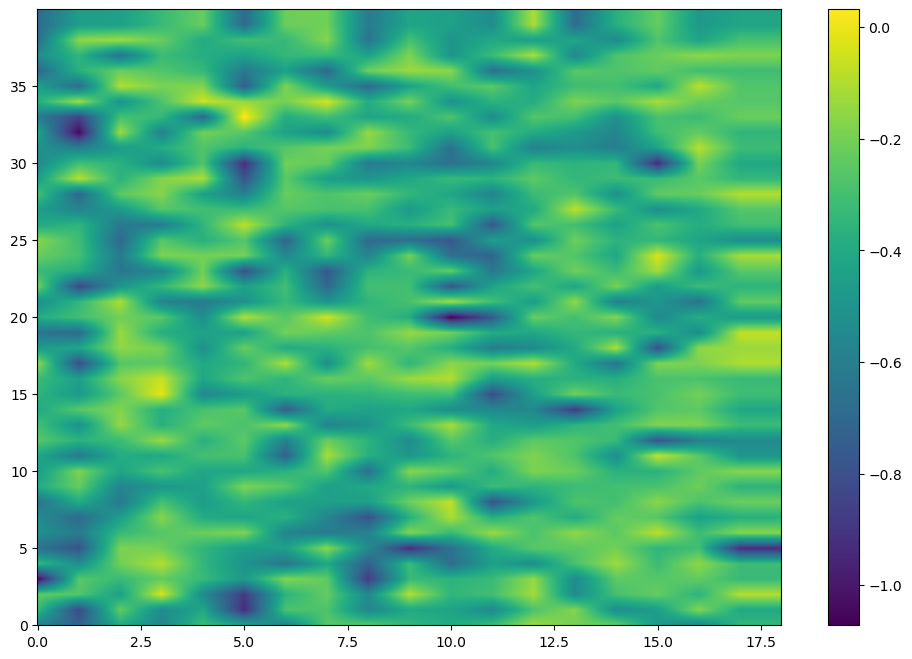

In [148]:
x_interp = arange(18)
y_interp = arange(40)
f = interpolate.interp2d(y_interp,x_interp,z_log)
xnew = arange(0, 18, 0.01)
ynew = arange(0,40, 0.01)
xx, yy = meshgrid(ynew, xnew)
znew = f(ynew, xnew)

fig, axs = plt.subplots(figsize = (12,8))
im = axs.pcolormesh(yy,xx,znew)
#im = axs.pcolormesh(x,y,z_integral)
#axs.set_xticks(, )
cbar = fig.colorbar(im)
#cbar.set_ticks([znew.min(),0,znew.max()],labels= ['N','Neutral', 'P'])